<a href="https://colab.research.google.com/github/securitylab-repository/TPS-IA/blob/master/solution_tp3_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Charger le dataset

In [55]:
import pandas as pd
import numpy as np
from IPython.display import display

dataset = pd.read_csv('https://github.com/securitylab-repository/TPS-IA/raw/master/payment_fraud.csv',delimiter=',')

In [116]:
dataset.head()

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label,income_cat
0,29,1,4.745402,paypal,28.204861,0,5
1,725,1,4.742303,storecredit,0.000000,0,5
2,845,1,4.921318,creditcard,0.000000,0,6
3,503,1,4.886641,creditcard,0.000000,0,6
4,2000,1,5.040929,creditcard,0.000000,0,6


# Créer l'ensemble d'entrainement et de test

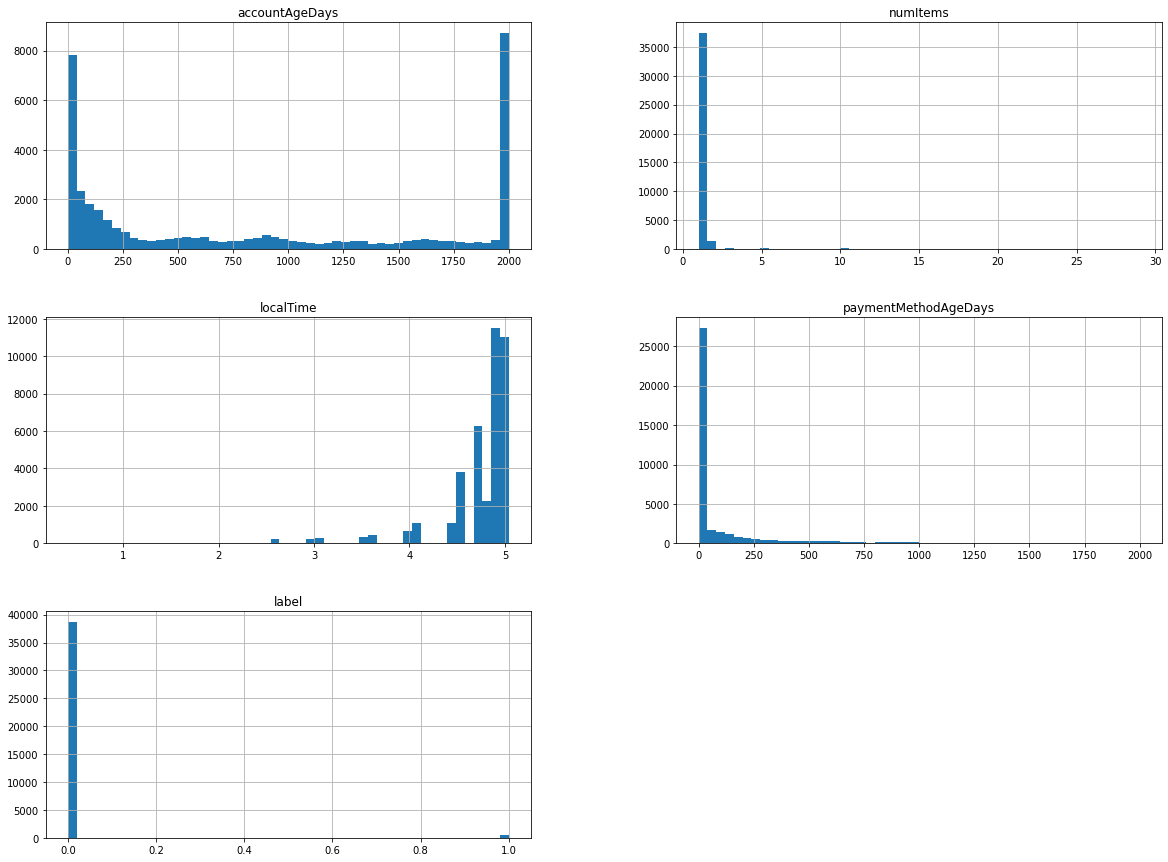

In [115]:
#%matplotlib inline   # Seulement dans Jupyter notebook
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [58]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
dataset["income_cat"] = pd.cut(dataset["localTime"],
                               bins=[0., 3, 3.5, 4, 4.6,4.8, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])
dataset["income_cat"].hist()

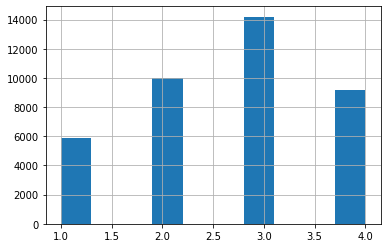

In [119]:

dataset["income_cat"] = pd.cut(dataset["accountAgeDays"],
                               bins=[0., 20, 250, 1900, np.inf],
                               labels=[1, 2, 3, 4])
dataset["income_cat"].hist()

In [145]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset["income_cat"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.361887
2    0.254175
4    0.234289
1    0.149649
Name: income_cat, dtype: float64

In [146]:
for set_ in (strat_train_set, strat_test_set): 
  set_.drop("income_cat", axis=1, inplace=True)



# Extraction des labels

In [147]:
train_set = strat_train_set.drop("label", axis=1)
test_set = strat_test_set.drop("label", axis=1)
train_labels =  strat_train_set["label"].copy()
test_labels =  strat_test_set["label"].copy()


# Traitement du dataset d'entrainement et de test

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
      
      return X


In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
      #  ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

train_set_num = train_set.drop("paymentMethod", axis=1)
train_set_num_tr = num_pipeline.fit_transform(train_set_num)

print(train_set_num_tr)

[[ 1.41980075 -0.15289597  0.44520813 -0.43282774]
 [-1.04785306 -0.15289597  0.44520813 -0.43282774]
 [-1.00809228  1.67254694 -0.57295891 -0.43282774]
 ...
 [ 1.41980075 -0.15289597  0.69308124  0.35699173]
 [ 1.41980075 -0.15289597  0.44528769 -0.43282774]
 [-0.82668369 -0.15289597  0.33088511  0.24859103]]


In [150]:
categorical_features = train_set.select_dtypes(['object', 'bool', 'category']).columns
print(categorical_features )
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


Index(['paymentMethod'], dtype='object')


In [151]:
numeric_features = train_set.select_dtypes(np.number).columns
print(numeric_features)

Index(['accountAgeDays', 'numItems', 'localTime', 'paymentMethodAgeDays'], dtype='object')


In [152]:
# Construct ColumnTransformer object
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    verbose=True)

In [153]:
train_set_prepared = full_pipeline.fit_transform(train_set)
enc_cat_features = full_pipeline.named_transformers_['cat']['onehot'].get_feature_names()
feature_names = np.concatenate([numeric_features, enc_cat_features])
feature_names


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['accountAgeDays', 'numItems', 'localTime', 'paymentMethodAgeDays',
       'x0_creditcard', 'x0_paypal', 'x0_storecredit'], dtype=object)

In [154]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#num_attribs = list(train_set_num)
#print("Attributs numériques {} : ".format(num_attribs))
#cat_attribs = ["paymentMethod"]

#full_pipeline = ColumnTransformer([
#        ("num", num_pipeline, num_attribs),
#        ("cat", OneHotEncoder(), cat_attribs),
 #   ])

#train_set_prepared = full_pipeline.fit_transform(train_set)


#print(train_set_prepared)

In [155]:
# prepare test set
test_set_prepared = full_pipeline.fit_transform(test_set)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s


# Entrainement Logistic Regression

In [156]:
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss="log", penalty="none")
lr.fit(train_set_prepared, train_labels)

SGDClassifier(loss='log', penalty='none')

In [157]:
from sklearn.metrics import mean_squared_error
train_predictions = lr.predict(train_set_prepared)
lin_mse = mean_squared_error(train_labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.11761049466297625

# Test Logistic Regression

In [158]:
# Calcul des erreurs de prédiction
# Validation
final_predictions = lr.predict(test_set_prepared)
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)   
print(final_rmse)

0.1272346462029558


# Entrainement Knn

In [159]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
k = 3
knn = KNeighborsClassifier(n_neighbors = k)
# Fit the classifier to the data
knn.fit(train_set_prepared,train_labels)

KNeighborsClassifier(n_neighbors=3)

In [160]:
from sklearn.metrics import mean_squared_error
train_predictions = knn.predict(train_set_prepared)
lin_mse = mean_squared_error(train_labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.043729734142099526

# Test Knn

In [161]:
# Calcul des erreurs de prédiction
# Validation
final_predictions = knn.predict(test_set_prepared)
final_mse = mean_squared_error(test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)   
print(final_rmse)

0.13406428069233273


## Fix velue of hyper-parameter K

In [138]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
#grid_search = GridSearchCV(knn, param_grid, cv=5,
#                           scoring='neg_mean_squared_error',
#                          return_train_score=True)
  
# fitting the model for grid search
grid_search=grid.fit(train_set_prepared, train_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [139]:
print(grid_search.best_params_)

{'n_neighbors': 2}


In [140]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 99.68%


# Choix d'un algorithme de machine learning - Cross Validation

In [141]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [142]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, train_set_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-scores)

display_scores(knn_rmse_scores)

Scores: [0.06183924 0.05920657 0.07140581 0.06183924 0.06913837 0.07360342
 0.0618491  0.06437458 0.059216   0.07141719]
Mean: 0.0653889513440544
Standard deviation: 0.0051881150912173315


In [143]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, train_set_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
lr_rmse_scores = np.sqrt(-scores)

display_scores(lr_rmse_scores)

Scores: [0.12496016 0.11841313 0.11705979 0.11841313 0.11975118 0.11705979
 0.12240289 0.11707845 0.11432328 0.118432  ]
Mean: 0.11878938119157119
Standard deviation: 0.0028518088282972697


# Sélection des meilleurs features

<BarContainer object of 7 artists>

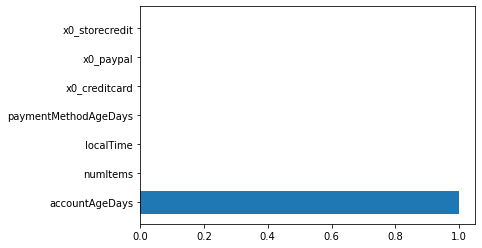

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_set_prepared, train_labels)
rf.feature_importances_
plt.barh(feature_names, rf.feature_importances_)